In [28]:
import torch
import torch.nn as nn
import random
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import time
# This cell was selected, but the error related to 'MOBILENET_model.pth' needs to be fixed in cell 'ihrOexCJALiu'.

In [2]:
train_trans=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224,scale=(0.80,1.0)),
    transforms.ColorJitter(brightness=0.2,contrast=0.2),
    transforms.ToTensor()
])
test_trans=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [4]:
Train_dataset = datasets.ImageFolder(
    "/content/drive/MyDrive/guvi/train",
    transform=train_trans
)

Test_dataset = datasets.ImageFolder(
    "/content/drive/MyDrive/guvi/test",
    transform=test_trans
)

Valid_dataset = datasets.ImageFolder(
    "/content/drive/MyDrive/guvi/valid",
    transform=test_trans)

train_loader=DataLoader(Train_dataset,batch_size=32,shuffle=True)
test_loader=DataLoader(Test_dataset,batch_size=3,shuffle=False)
valid_loader=DataLoader(Valid_dataset,batch_size=32,shuffle=False)

In [5]:
def count_images(dataset):
  count=[0]*len(dataset.classes)
  for path,label in dataset.samples:
    count[label]=count[label]+1
  return dict(zip(dataset.classes,count))

print(count_images(Train_dataset))
print(count_images(Test_dataset))
print(count_images(Valid_dataset))


{'bird': 1414, 'drone': 1248}
{'bird': 121, 'drone': 94}
{'bird': 217, 'drone': 225}


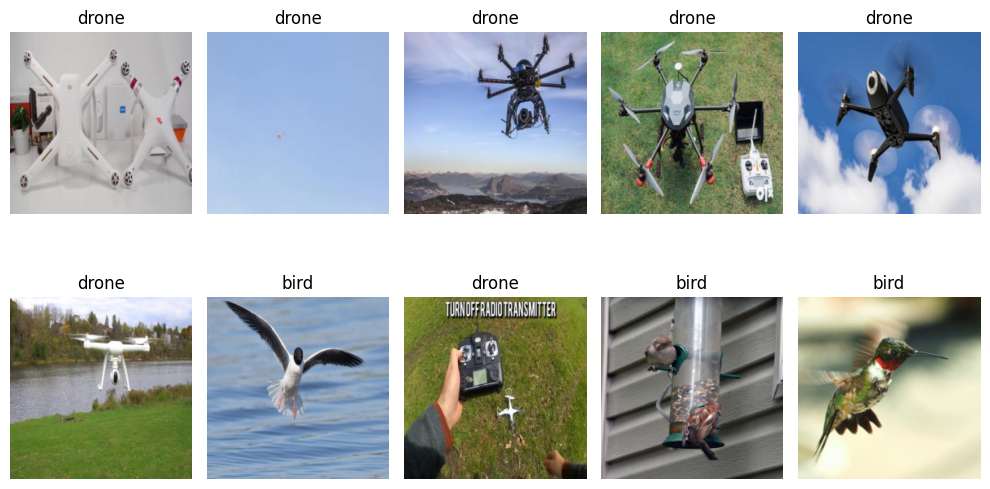

In [7]:
preview_data=datasets.ImageFolder("/content/drive/MyDrive/guvi/train",transform=test_trans)

plt.figure(figsize=(10,6))

for i in range(10):
  img,label=preview_data[random.randint(0,len(preview_data)-1)]
  img=img.permute(1,2,0)
  plt.subplot(2,5,i+1)
  plt.imshow(img)
  plt.title(preview_data.classes[label])
  plt.axis('off')
plt.tight_layout()
plt.show()

In [8]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv=nn.Sequential(
        nn.Conv2d(3,16,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(16,32,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
    )
    self.fc=nn.Sequential(
        nn.Linear(32*56*56,128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128,1)
    )
  def forward(self,x):
    conv=self.conv(x)
    flat=conv.view(conv.size(0),-1)
    fc=self.fc(flat)
    return fc

In [9]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)


Using: cuda


In [10]:
model = CNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_loss = float('inf')
patience = 5
wait = 0

epochs = 5

for epoch in range(epochs):
    # ---------- Training ----------
    model.train()
    train_loss = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.unsqueeze(1).float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # ---------- Validation ----------
    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.unsqueeze(1).float().to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.round(torch.sigmoid(outputs))
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    val_loss /= len(valid_loader)

    # Calculate accuracy
    all_preds = [int(p[0]) for p in all_preds]
    all_labels = [int(l[0]) for l in all_labels]
    accuracy = accuracy_score(all_labels, all_preds)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Accuracy: {accuracy:.4f}")

    # ---------- Early Stopping ----------
    if val_loss < best_loss:
        best_loss = val_loss
        wait = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("✔ Model improved — saved!")
    else:
        wait += 1
        print(f"⚠ No improvement ({wait}/{patience})")

        if wait >= patience:
            print("\n⛔ Early stopping triggered.")
            break

print("\n🎉 Training Completed!")

Epoch 1/5 | Train Loss: 0.6472 | Val Loss: 0.5681 | Accuracy: 0.7104
✔ Model improved — saved!
Epoch 2/5 | Train Loss: 0.5599 | Val Loss: 0.5991 | Accuracy: 0.6900
⚠ No improvement (1/5)
Epoch 3/5 | Train Loss: 0.5168 | Val Loss: 0.4869 | Accuracy: 0.7715
✔ Model improved — saved!
Epoch 4/5 | Train Loss: 0.4800 | Val Loss: 0.5341 | Accuracy: 0.7285
⚠ No improvement (1/5)
Epoch 5/5 | Train Loss: 0.4718 | Val Loss: 0.4533 | Accuracy: 0.7715
✔ Model improved — saved!

🎉 Training Completed!


In [11]:
# Load best model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.unsqueeze(1).float().to(device)

        outputs = model(images)
        preds = torch.round(torch.sigmoid(outputs))

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to integers
all_preds = [int(p[0]) for p in all_preds]
all_labels = [int(l[0]) for l in all_labels]

# Metrics
accuracy = accuracy_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds)

print("\n===== TEST RESULTS =====")
print(f"✔ Accuracy: {accuracy:.4f}")
print("\n🔹 Confusion Matrix:")
print(cm)
print("\n🔹 Classification Report:")
print(report)



===== TEST RESULTS =====
✔ Accuracy: 0.8233

🔹 Confusion Matrix:
[[103  18]
 [ 20  74]]

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       121
           1       0.80      0.79      0.80        94

    accuracy                           0.82       215
   macro avg       0.82      0.82      0.82       215
weighted avg       0.82      0.82      0.82       215



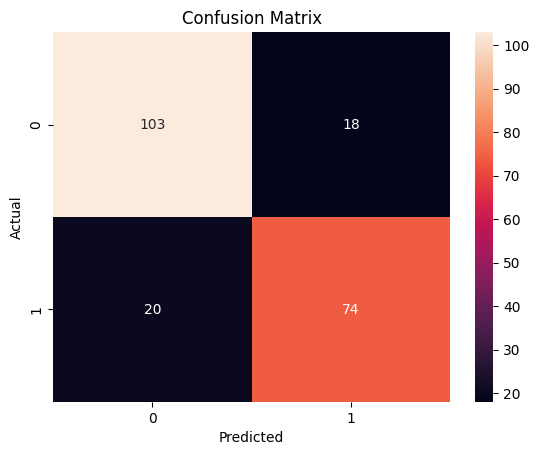

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [13]:
import torchvision.models as models

### predifined model for resnet50
def resnet50():
  model=models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
  model.fc=nn.Linear(model.fc.in_features,1)

  for name,param in model.named_parameters():
    if "Layer4" in name:
      param.requireds_grad=True
    else:
      param.requireds_grad=False
  return model

### predifined model for mobilenetv2
def mobilenet_v2():
  model=models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
  model.classifier[1]=nn.Linear(model.last_channel,1)

  for name,param in model.named_parameters():
    if "features.17" in name:
      param.requireds_grad=True
    else:
      param.requireds_grad=False
  return model

### predefined model for efficientnetb0
def efficientnet_b0():
  model=models.efficientnet_b0(pretrained=True)
  model.classifier[1]=nn.Linear(model.classifier[1].in_features,1)

  for name,param in model.named_parameters():
    if "features.6" in name:
      param.requireds_grad=True
    else:
      param.requireds_grad=False
  return model


In [14]:
resnet=resnet50().to(device)
criterion=nn.BCEWithLogitsLoss()
optimizer=torch.optim.Adam(filter(lambda x:x.requires_grad,resnet.parameters()),lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 123MB/s]


In [15]:
counter = 0
patience = 6
checkpoint = "RESNET_model.pth"
best_valid_loss = float("inf")

epochs = 5
r_train_losses = []
r_valid_losses = []
r_valid_accuracy = []

start_time = time.time()

for epoch in range(epochs):

    # ---------------- TRAIN ---------------- #
    resnet.train()
    running_loss = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.unsqueeze(1).float().to(device)

        optimizer.zero_grad()
        preds = resnet(images)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    r_train_losses.append(train_loss)
    print(f"\nEpoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}")

    # ---------------- VALIDATION ---------------- #
    resnet.eval()
    y_pred, y_true = [], []
    valid_loss = 0.0

    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.unsqueeze(1).float().to(device)

            outputs = resnet(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            preds = torch.round(torch.sigmoid(outputs))
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    # Convert lists
    y_pred = [int(x[0]) for x in y_pred]
    y_true = [int(x[0]) for x in y_true]

    valid_loss /= len(valid_loader)
    r_valid_losses.append(valid_loss)

    accuracy = accuracy_score(y_true, y_pred)
    r_valid_accuracy.append(accuracy)

    print(f"Validation Loss: {valid_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))

    # ---------------- EARLY STOPPING ---------------- #
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        counter = 0
        torch.save(resnet.state_dict(), checkpoint)
        print("✔ Model improved — saved.")
    else:
        counter += 1
        if counter >= patience:
            print("⛔ Early Stopping triggered!")
            break

end_time = time.time()
print(f"\nTraining Time: {(end_time - start_time) / 60:.2f} minutes")


Epoch 1/5 - Train Loss: 0.2998
Validation Loss: 0.5138
Accuracy: 0.8258
Confusion Matrix:
 [[212   5]
 [ 72 153]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.98      0.85       217
           1       0.97      0.68      0.80       225

    accuracy                           0.83       442
   macro avg       0.86      0.83      0.82       442
weighted avg       0.86      0.83      0.82       442

✔ Model improved — saved.

Epoch 2/5 - Train Loss: 0.1953
Validation Loss: 0.2771
Accuracy: 0.9253
Confusion Matrix:
 [[214   3]
 [ 30 195]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.99      0.93       217
           1       0.98      0.87      0.92       225

    accuracy                           0.93       442
   macro avg       0.93      0.93      0.93       442
weighted avg       0.93      0.93      0.93       442

✔ Model improved — saved.

Epoch 3/5 - Tra

In [24]:
mobilenet=mobilenet_v2().to(device)
criterion=nn.BCEWithLogitsLoss()
optimizer=torch.optim.Adam(filter(lambda x:x.requires_grad,mobilenet.parameters()),lr=0.001)


In [29]:
counter = 0
patience = 6
checkpoint = "MOBILENET_model.pth"
best_valid_loss = float("inf")

epochs = 5
m_train_losses = []
m_valid_losses = []
m_valid_accuracy = []

start_time = time.time()

for epoch in range(epochs):

    # ---------------- TRAIN ---------------- #
    mobilenet.train()
    running_loss = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.unsqueeze(1).float().to(device)

        optimizer.zero_grad()
        preds = mobilenet(images)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    m_train_losses.append(train_loss)
    print(f"\nEpoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}")

    # ---------------- VALIDATION ---------------- #
    mobilenet.eval()
    y_pred, y_true = [], []
    valid_loss = 0.0

    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.unsqueeze(1).float().to(device)

            outputs = mobilenet(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            preds = torch.round(torch.sigmoid(outputs))
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    # Convert lists
    y_pred = [int(x[0]) for x in y_pred]
    y_true = [int(x[0]) for x in y_true]

    valid_loss /= len(valid_loader)
    m_valid_losses.append(valid_loss)

    accuracy = accuracy_score(y_true, y_pred)
    m_valid_accuracy.append(accuracy)

    print(f"Validation Loss: {valid_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))

    # ---------------- EARLY STOPPING ---------------- #
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        counter = 0
        torch.save(mobilenet.state_dict(), checkpoint)
        print("✔ Model improved — saved.")
    else:
        counter += 1
        if counter >= patience:
            print("⛔ Early Stopping triggered!")
            break

end_time = time.time()
print(f"\nTraining Time: {(end_time - start_time) / 60:.2f} minutes")


Epoch 1/5 - Train Loss: 0.0660
Validation Loss: 0.0978
Accuracy: 0.9683
Confusion Matrix:
 [[209   8]
 [  6 219]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97       217
           1       0.96      0.97      0.97       225

    accuracy                           0.97       442
   macro avg       0.97      0.97      0.97       442
weighted avg       0.97      0.97      0.97       442

✔ Model improved — saved.

Epoch 2/5 - Train Loss: 0.0685
Validation Loss: 0.0737
Accuracy: 0.9683
Confusion Matrix:
 [[210   7]
 [  7 218]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       217
           1       0.97      0.97      0.97       225

    accuracy                           0.97       442
   macro avg       0.97      0.97      0.97       442
weighted avg       0.97      0.97      0.97       442

✔ Model improved — saved.

Epoch 3/5 - Tra

In [27]:
mobilenet.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = mobilenet(images)
        preds = torch.round(torch.sigmoid(outputs))

        # Convert to Python ints
        y_true.extend(labels.cpu().numpy().astype(int).tolist())
        y_pred.extend(preds.cpu().numpy().astype(int).tolist())

# Flatten if needed
y_true = [x if isinstance(x, int) else x[0] for x in y_true]
y_pred = [x if isinstance(x, int) else x[0] for x in y_pred]

# Metrics
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

Accuracy: 0.9255813953488372
Confusion Matrix:
 [[121   0]
 [ 16  78]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.94       121
           1       1.00      0.83      0.91        94

    accuracy                           0.93       215
   macro avg       0.94      0.91      0.92       215
weighted avg       0.93      0.93      0.92       215



In [19]:
efficientnet = efficientnet_b0().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(efficientnet.parameters(), lr=0.001)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 59.1MB/s]


In [20]:
counter = 0
patience = 6
checkpoint = "EFFICIENTNET_model.pth"
best_valid_loss = float("inf")

epochs = 5

ef_train_losses = []
ef_valid_losses = []
ef_valid_acc = []

start_time = time.time()

for epoch in range(epochs):

    # --- TRAINING ---
    efficientnet.train()
    running_loss = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = efficientnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    ef_train_losses.append(train_loss)
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}")

    # --- VALIDATION ---
    efficientnet.eval()
    valid_loss = 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = efficientnet(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            preds = torch.round(torch.sigmoid(outputs))

            y_true.extend(labels.cpu().numpy().astype(int).tolist())
            y_pred.extend(preds.cpu().numpy().astype(int).tolist())

    valid_loss = valid_loss / len(valid_loader)
    ef_valid_losses.append(valid_loss)

    # flatten lists
    y_true = [x[0] for x in y_true]
    y_pred = [x[0] for x in y_pred]

    # accuracy
    accuracy = accuracy_score(y_true, y_pred)
    ef_valid_acc.append(accuracy)

    print(f"Validation Loss: {valid_loss:.4f}  |  Accuracy: {accuracy:.4f}")
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

    # --- EARLY STOPPING ---
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        counter = 0
        torch.save(efficientnet.state_dict(), checkpoint)
        print("Model Saved!")
    else:
        counter += 1
        if counter >= patience:
            print("Early Stopping Triggered!")
            break

end_time = time.time()
print(f"Total Training Time: {(end_time - start_time)/60:.2f} minutes")

Epoch 1/5 - Train Loss: 0.1995
Validation Loss: 0.0894  |  Accuracy: 0.9661
[[206  11]
 [  4 221]]
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       217
           1       0.95      0.98      0.97       225

    accuracy                           0.97       442
   macro avg       0.97      0.97      0.97       442
weighted avg       0.97      0.97      0.97       442

Model Saved!
Epoch 2/5 - Train Loss: 0.0981
Validation Loss: 0.1026  |  Accuracy: 0.9638
[[211   6]
 [ 10 215]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       217
           1       0.97      0.96      0.96       225

    accuracy                           0.96       442
   macro avg       0.96      0.96      0.96       442
weighted avg       0.96      0.96      0.96       442

Epoch 3/5 - Train Loss: 0.0820
Validation Loss: 0.1713  |  Accuracy: 0.9525
[[201  16]
 [  5 220]]
              precision    recall  f

In [21]:
efficientnet.eval()

y_pred = []
y_true = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.unsqueeze(1).float().to(device)

        outputs = efficientnet(images)
        preds = torch.round(torch.sigmoid(outputs))  # 0 or 1

        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Convert to int
y_pred = [int(p[0]) for p in y_pred]
y_true = [int(t[0]) for t in y_true]

accuracy = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

Accuracy: 0.9813953488372092
Confusion Matrix:
 [[121   0]
 [  4  90]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98       121
           1       1.00      0.96      0.98        94

    accuracy                           0.98       215
   macro avg       0.98      0.98      0.98       215
weighted avg       0.98      0.98      0.98       215



In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

models_list = [
    ("ResNet", resnet, "RESNET_model.pth"),
    ("MobileNet", mobilenet, "MOBILENET_model.pth"),
    ("EfficientNet", efficientnet, "EFFICIENTNET_model.pth")
]

for name, model, path in models_list:

    print(f"\n========== {name} TEST RESULTS ==========")

    # Load best weights
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()

    y_preds = []
    y_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.unsqueeze(1).float().to(device)

            outputs = model(images)
            preds = torch.round(torch.sigmoid(outputs))

            y_preds.extend(preds.cpu().tolist())
            y_labels.extend(labels.cpu().tolist())

    # Convert to int
    y_preds = [int(x[0]) for x in y_preds]
    y_labels = [int(x[0]) for x in y_labels]

    accuracy = accuracy_score(y_labels, y_preds)
    confusion = confusion_matrix(y_labels, y_preds)
    report = classification_report(y_labels, y_preds)

    print("Accuracy:", accuracy)
    print("Confusion Matrix:\n", confusion)
    print("Classification Report:\n", report)


========== ResNet TEST RESULTS ==========
Accuracy: 0.9488372093023256
Confusion Matrix:
 [[120   1]
 [ 10  84]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.96       121
           1       0.99      0.89      0.94        94

    accuracy                           0.95       215
   macro avg       0.96      0.94      0.95       215
weighted avg       0.95      0.95      0.95       215


========== MobileNet TEST RESULTS ==========
Accuracy: 0.9534883720930233
Confusion Matrix:
 [[120   1]
 [  9  85]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96       121
           1       0.99      0.90      0.94        94

    accuracy                           0.95       215
   macro avg       0.96      0.95      0.95       215
weighted avg       0.96      0.95      0.95       215


========== EfficientNet TEST RESULTS ==========
Accuracy: 0.981395

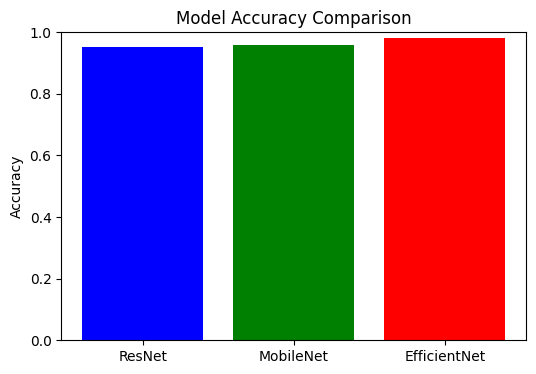

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ======================
# 1️⃣ Accuracy Comparison
# ======================
model_names = ["ResNet", "MobileNet", "EfficientNet"]
accuracies = [0.9535, 0.9581, 0.9814]  # replace with your test accuracies

plt.figure(figsize=(6,4))
plt.bar(model_names, accuracies, color=["blue", "green", "red"])
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("Model Accuracy Comparison")
plt.show()




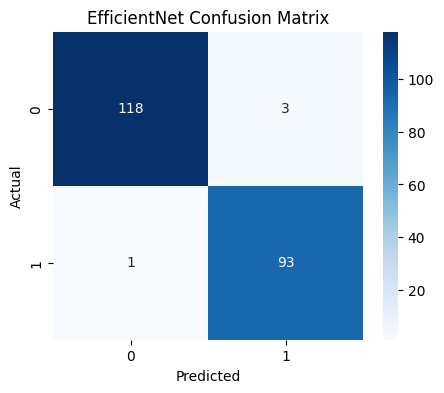

In [33]:
# ======================
# 2️⃣ Confusion Matrix for EfficientNet
# ======================
# Use y_labels and y_preds from EfficientNet test evaluation
cm = confusion_matrix(y_labels, y_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("EfficientNet Confusion Matrix")
plt.show()



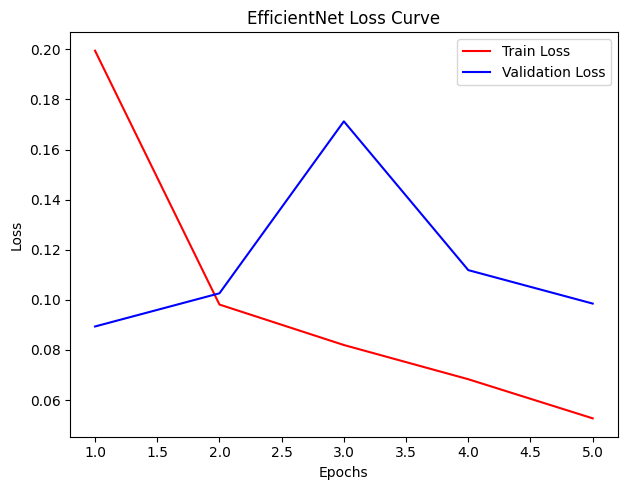

In [34]:
# ======================
# 3️⃣ Training & Validation Loss Curves for EfficientNet
# ======================
# If ef_valid_accuracy was not saved, skip accuracy curve
epochs = range(1, len(ef_train_losses)+1)

plt.figure(figsize=(12,5))

# Loss curve
plt.subplot(1,2,1)
plt.plot(epochs, ef_train_losses, 'r-', label='Train Loss')
plt.plot(epochs, ef_valid_losses, 'b-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('EfficientNet Loss Curve')
plt.legend()

# Accuracy curve (optional if available)
if 'ef_valid_accuracy' in globals():
    plt.subplot(1,2,2)
    plt.plot(epochs, ef_valid_accuracy, 'g-', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('EfficientNet Accuracy Curve')
    plt.ylim(0, 1)
    plt.legend()

plt.tight_layout()
plt.show()

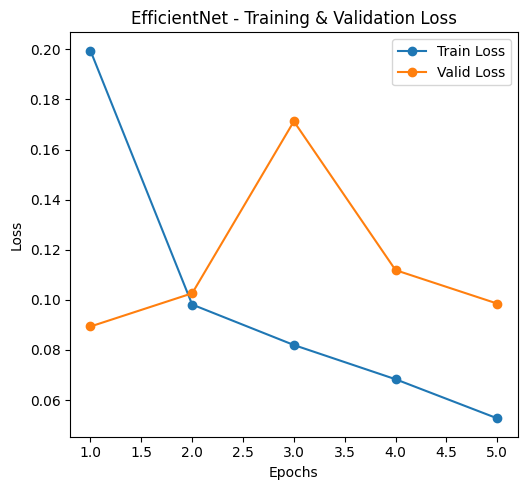

In [35]:
epochs = range(1, len(ef_train_losses)+1)

plt.figure(figsize=(10,5))

# Loss plot
plt.subplot(1,2,1)
plt.plot(epochs, ef_train_losses, label="Train Loss", marker='o')
plt.plot(epochs, ef_valid_losses, label="Valid Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("EfficientNet - Training & Validation Loss")
plt.legend()

# Accuracy plot (if saved separately)
if 'ef_valid_accuracy' in globals():
    plt.subplot(1,2,2)
    plt.plot(epochs, ef_valid_accuracy, label="Valid Accuracy", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("EfficientNet - Validation Accuracy")
    plt.ylim(0, 1)
    plt.legend()

plt.tight_layout()
plt.show()


In [43]:
%%writefile app.py
import streamlit as st
from PIL import Image
import torch
from torchvision import transforms, models
import torch.nn as nn

# -------------------------------
# Model definition
# -------------------------------
def efficientnet_b0():
    model = models.efficientnet_b0(pretrained=False)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)
    return model

# Load model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = efficientnet_b0().to(device)
model.load_state_dict(torch.load("EFFICIENTNET_model.pth", map_location=device))
model.eval()

# -------------------------------
# Transform
# -------------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# -------------------------------
# Streamlit UI
# -------------------------------
st.title("Aerial Object Classification")

uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption='Uploaded Image', use_column_width=True)

    # Preprocess
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        output = model(input_tensor)
        prob = torch.sigmoid(output).item()
        conf = prob*100 if prob >= 0.5 else (1-prob)*100
        pred_label = "Drone" if prob > 0.5 else "Bird"

    st.success(f"Predicted Label: {pred_label}")
    st.info(f"Confidence: {conf:.2f}%")

else:
    st.warning("Please upload an image file (jpg, jpeg, png) to get prediction.")

Overwriting app.py


In [45]:
!streamlit run app.py




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.34.76.11:8501

  Stopping...
  Stopping...


In [37]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 100.8 MB/s eta 0:00:00
